In [128]:
import nltk
#need natin ito para mag work ang nltk. bale ang nltk ang mag support sa data preparation
#nltk.download()#this will open the nltk download manager
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from spellchecker import SpellChecker
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import sparse
import re
import csv 

In [2]:
#pip install pyspellchecker
#pip install spellchecker
dataframe = pd.read_csv('essay_set_descriptions.csv',encoding = 'latin-1')

dataframe.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score
count,12978.000000,12978.000000,12977.000000,12977.000000,12977.000000
mean,10295.432809,4.179458,4.126840,4.137089,6.799723
std,6308.588616,2.136749,4.212537,4.264320,8.970558
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4439.250000,2.000000,2.000000,2.000000,2.000000
50%,10045.500000,4.000000,3.000000,3.000000,3.000000
75%,15680.750000,6.000000,4.000000,4.000000,8.000000
max,21633.000000,8.000000,30.000000,30.000000,60.000000


In [3]:
dataframe.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [4]:
#checking the dataframe columns
dataframe.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score'],
      dtype='object')

In [6]:
#checking the data on first column
dataframe.essay_id


0            1
1            2
2            3
3            4
4            5
         ...  
12973    21626
12974    21628
12975    21629
12976    21630
12977    21633
Name: essay_id, Length: 12978, dtype: int64

In [7]:
data = dataframe[['essay_set','essay','domain1_score']].copy()

print(data)

       essay_set                                              essay  \
0              1  Dear local newspaper, I think effects computer...   
1              1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2              1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3              1  Dear Local Newspaper, @CAPS1 I have found that...   
4              1  Dear @LOCATION1, I know having computers has a...   
...          ...                                                ...   
12973          8   In most stories mothers and daughters are eit...   
12974          8   I never understood the meaning laughter is th...   
12975          8  When you laugh, is @CAPS5 out of habit, or is ...   
12976          8                                 Trippin' on fen...   
12977          8   Many people believe that laughter can improve...   

       domain1_score  
0                8.0  
1                9.0  
2                7.0  
3               10.0  
4                8.0  
...      

<AxesSubplot:title={'center':'domain1_score'}, xlabel='essay_set'>

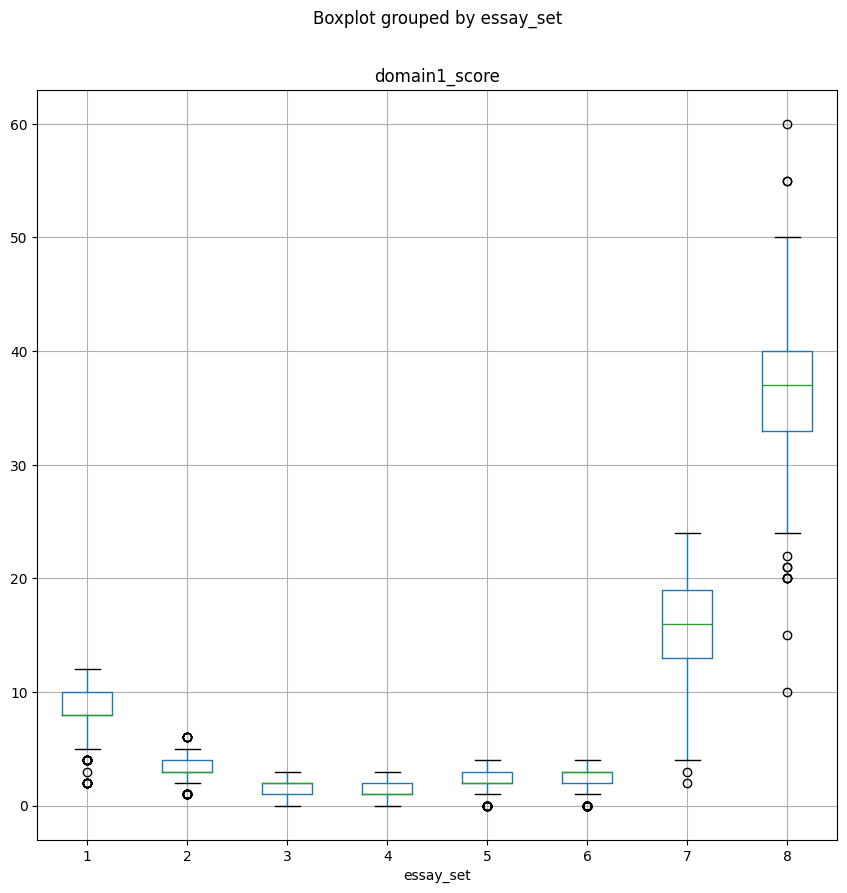

In [8]:
#plotting
%matplotlib inline
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [9]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set(dataframe,setNumber):
    if setNumber == 1783:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        for i in range(1,1783):
            dataframe2 = dataframe[dataframe.values == 1]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
    return texts, scores


In [11]:
# get histogram plot of scores and average score
def get_hist_avg(scores,bin_count):
    print(sum(scores)/len(scores))
    scores.hist(bins=bin_count)

In [12]:
#average word length for a text
def avg_word_len(text):
    clean_essay = re.sub(r'\W', ' ', text)
    words = nltk.word_tokenize(clean_essay)
    total = 0
    for word in words:
        total = total + len(word)
    average = total / len(words)
    
    return average

# word count in a given text
def word_count(text):
    clean_essay = re.sub(r'\W', ' ', text)
    return len(nltk.word_tokenize(clean_essay))

# char count in a given text
def char_count(text):
    return len(re.sub(r'\s', '', str(text).lower()))

# sentence count in a given text
def sent_count(text):
    return len(nltk.sent_tokenize(text))

#tokenization of texts to sentences
def sent_tokenize(text):
    stripped_essay = text.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
            tokens = nltk.word_tokenize(clean_sentence)
            tokenized_sentences.append(tokens)
    return tokenized_sentences


# lemma, noun, adjective, verb, adverb count for a given text

def count_lemmas(text):
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0   
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    tokenized_sentences = sent_tokenize(text)
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('N'): 
                noun_count += 1
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                adj_count += 1
                pos = wordnet.ADJ
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                verb_count += 1
                pos = wordnet.VERB
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                adv_count += 1
                pos = wordnet.ADV
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return noun_count, adj_count, verb_count, adv_count, lemma_count

In [13]:
def token_word(text):
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return tokens

In [14]:
def misspell_count(text):
    spelling = SpellChecker()
    # find those words that may be misspelled
    misspelled = spelling.unknown(token_word(text))
    #print(misspelled)
    return len(misspelled)

In [15]:
def create_features(texts):
    data = pd.DataFrame(columns=('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' , 'Misspell_Count'
                                 ))

    data['Average_Word_Length'] = texts.apply(avg_word_len)
    data['Sentence_Count'] = texts.apply(sent_count)
    data['Word_Count'] = texts.apply(word_count)
    data['Character_Count'] = texts.apply(char_count)
    temp=texts.apply(count_lemmas)
    noun_count,adj_count,verb_count,adverb_count,lemma_count = zip(*temp)
    data['Noun_Count'] = noun_count
    data['Adjective_Count'] = adj_count
    data['Verb_Count'] = verb_count
    data['Adverb_Count'] = adverb_count
    data['Lemma_Count'] = lemma_count
    data['Misspell_Count'] = texts.apply(misspell_count)
    return data


In [17]:
#checking create features if it is working
#print(texts)

In [44]:
def data_prepare(texts,scores):
    #create features from the texts and clean non graded essays
    data = create_features(texts)
    data.describe()
    t1=np.where(np.asanyarray(np.isnan(scores)))
    scores=scores.drop(scores.index[t1])
    data=data.drop(scores.index[t1])
     #train test split
    X_train, X_test, y_train, y_test = train_test_split(data, scores, test_size = 0.3)
    print(X_train)
    #checking is there any nan cells
    print(np.any(np.isnan(scores)))
    print(np.all(np.isfinite(scores)))
    #return np.sqrt(metrics.mean_squared_error(X_train, X_test, y_train, y_test, data))
    #knn = KNeighborsClassifier(n_neighbors=10)
    #knn.fit(X_train, y_train)
    #print('Coefficients: \n', linear_regressor.coef_)

    # The mean squared error
   # print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

    # Explained variance score: 1 is perfect prediction
   # print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

    #Cohen’s kappa score: 1 is complete agreement
    #print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(scores), y_test))
    return X_train, X_test, y_train, y_test, data


In [45]:
print(data,scores)

       essay_set                                              essay  \
0              1  Dear local newspaper, I think effects computer...   
1              1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2              1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3              1  Dear Local Newspaper, @CAPS1 I have found that...   
4              1  Dear @LOCATION1, I know having computers has a...   
...          ...                                                ...   
12973          8   In most stories mothers and daughters are eit...   
12974          8   I never understood the meaning laughter is th...   
12975          8  When you laugh, is @CAPS5 out of habit, or is ...   
12976          8                                 Trippin' on fen...   
12977          8   Many people believe that laughter can improve...   

       domain1_score  
0                8.0  
1                9.0  
2                7.0  
3               10.0  
4                8.0  
...      

In [46]:
# Training a Linear Regression model using only Bag of Words (BOW)
def lin_regression(X_train,y_train,X_test,y_test):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))
    

In [47]:
def adaBoost_reg(X_train,y_train,X_test,y_test):
    #regr = RandomForestRegressor(max_depth=2, n_estimators=300)
    #regr = SVR(gamma='scale', C=1, kernel='linear')
    regr = AdaBoostRegressor()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))

    feature_importance = regr.feature_importances_

    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_names = list(('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' ,'Misspell_Count'
                                 ))
    feature_names = np.asarray(feature_names)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [48]:
# convert numerical scores to labels
# (0-1.5) bad (1.5-2.3) average (2.3-3) good
# bad:    '0'
# average '1'
# good    '2'
def convert_scores(scores):
    def mapping(x):
        if x < np.percentile(scores,25):
            return 0
        elif x < np.percentile(scores,75):
            return 1
        else:
            return 2
    return scores.apply(mapping)

In [49]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set_classification(dataframe,setNumber):
    if setNumber == 1784:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
        for i in range(1,1783):
            dataframe2 = dataframe[dataframe.essay_set  == i]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            s = convert_scores(s)
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set  ==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
        print
    return texts, scores


2.132080762759394
      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
1244             4.210769              52         650             2858   
1143             4.705000              27         400             1954   
143              4.156951              31         446             1898   
1669             4.122970              32         431             1863   
1617             4.248340              36         753             3252   
...                   ...             ...         ...              ...   
37               4.230114              17         352             1516   
1397             4.353612              21         263             1174   
1492             4.236979              18         384             1686   
1210             4.598753              46         481             2283   
973              4.246291              17         337             1456   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
1244         173 

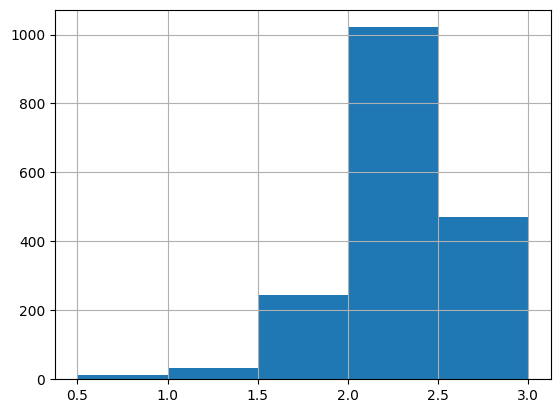

In [50]:
# 1-8
# 9:all sets combined
texts, scores = select_set(dataframe,1)
get_hist_avg(scores,5)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)


Testing for Linear Regression 

Mean squared error: 0.03803695551303957
Mean squared error in percentage: 1.267898517101319
Variance score: 0.7071286165178452
Testing for Adaboost Regression 

Mean squared error: 0.03855269395244447
Mean squared error in percentage: 1.2850897984148155
Variance score: 0.7031576091586558


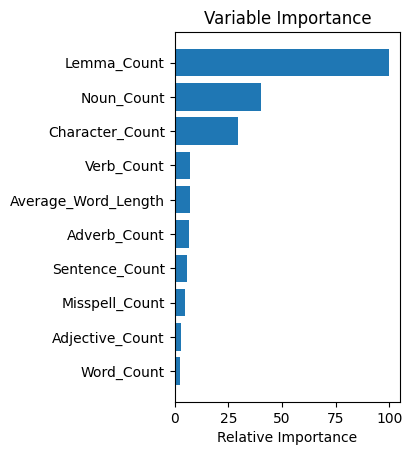

In [51]:
print('Testing for Linear Regression \n')
lin_regression(X_train,y_train,X_test,y_test)
print('Testing for Adaboost Regression \n')
adaBoost_reg(X_train,y_train,X_test,y_test)

In [52]:
#Dataset selection 2
# 1-8
# 9:all sets combined
texts, scores = select_set_classification(dataframe,1)
X_train, X_test, y_train, y_test,data = data_prepare(texts,scores)



      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
405              4.707792              16         308             1483   
256              4.157044              20         433             1840   
915              4.148968              40         678             2903   
695              3.875519               6         241              954   
346              4.101124              15         267             1120   
...                   ...             ...         ...              ...   
961              4.487476              33         519             2385   
871              4.739292              39         537             2647   
556              4.700587              25         511             2487   
1595             4.049275              19         345             1452   
670              4.400000               8         125              573   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
405           81               13  

In [53]:
# 1-8
# 9:all sets combined
texts, scores = select_set_classification(dataframe,1)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
848              4.337634              26         465             2088   
1752             4.193416              10         243             1043   
1711             4.023973               7         292             1197   
1189             4.492126              38         508             2337   
1173             4.139303              11         201              858   
...                   ...             ...         ...              ...   
1724             4.431085              19         341             1554   
1083             3.935561              25         419             1706   
445              4.477855              22         429             1995   
1186             4.037267              34         483             2001   
183              3.912371              16         388             1551   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
848          116               38  

In [60]:
#Classification analysis
a=[0.1,1,10,100,500,1000]
for b in a:
    clf = svm.SVC(C=b, gamma=0.00001)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    print (b)
    print (clf.score(X_test,y_test))
    print (np.mean(cross_val_score(clf, X_train, y_train, cv=3)))

0.1
0.7626168224299066
0.7908653846153846
1
0.7738317757009345
0.7876602564102564
10
0.7738317757009345
0.794871794871795
100
0.7738317757009345
0.7932692307692308
500
0.7757009345794392
0.7900641025641025
1000
0.7794392523364486
0.78125


In [63]:

clf = svm.SVC(C=100, gamma=0.00001)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print('Cohen’s kappa score: {}'.format(cohen_kappa_score(y_test,y_pred)))


Cohen’s kappa score: 0.5971385542168675


In [64]:
## Training a Linear Regression model using only 10 numerical/POS/orthographic features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


Coefficients: 
 [ 3.42726358e-01  8.73820290e-03  2.67043586e-03  2.98236455e-06
 -2.10887393e-04  7.48912354e-04 -5.01788317e-03 -3.76106191e-04
  4.60430491e-03 -3.49965637e-03]
Mean squared error: 0.17
Variance score: 0.60
Cohen's kappa score: 0.57


In [74]:
# Training a Ridge Regression model (l2 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


0.594327011516988
0.3
Mean squared error: 0.17
Variance score: 0.60
Cohen's kappa score: 0.57


In [75]:
# Training a Lasso Regression model (l1 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0.3, 0.1, 0.3])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.5912398142288945
0.1
Mean squared error: 0.17
Variance score: 0.61
Cohen's kappa score: 0.55


<AxesSubplot:ylabel='count'>

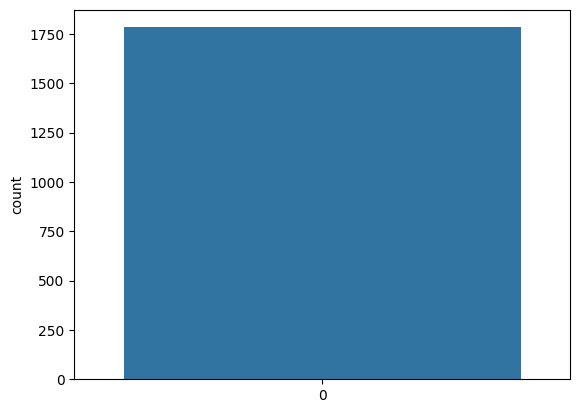

In [68]:
#Data Analysis
sns.countplot(scores)

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\496599478.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zero["Character_Count"], bins=10, color='r')
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\496599478.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(one["Character_Count"], b

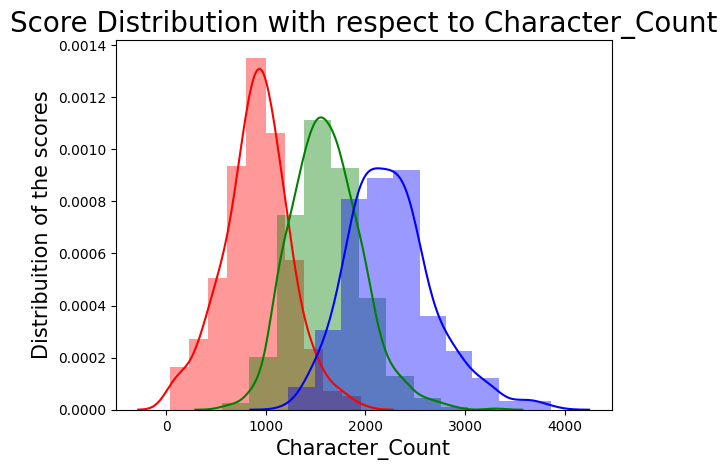

In [69]:
zero = data[(data["Character_Count"] > 0) & (scores == 0)]
one = data[(data["Character_Count"] > 0) & (scores == 1)]
two = data[(data["Character_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Character_Count"], bins=10, color='r')
sns.distplot(one["Character_Count"], bins=10, color='g')
sns.distplot(two["Character_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to Character_Count",fontsize=20)
plt.xlabel("Character_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2269970282.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zero["Lemma_Count"], bins=10, color='r')
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2269970282.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(one["Lemma_Count"], bins=10

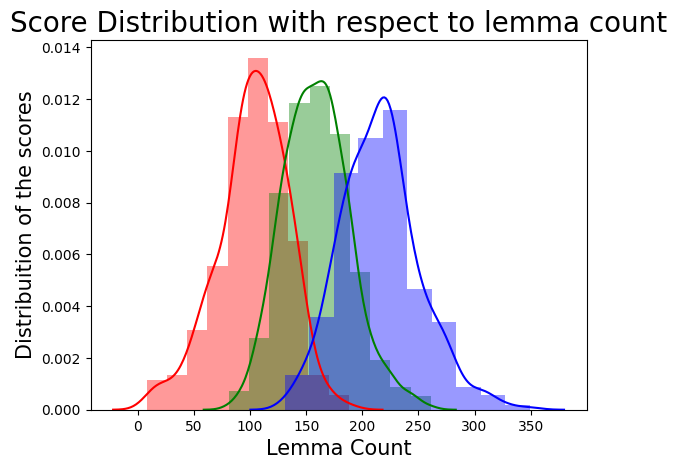

In [70]:
zero = data[(data["Lemma_Count"] > 0) & (scores == 0)]
one = data[(data["Lemma_Count"] > 0) & (scores == 1)]
two = data[(data["Lemma_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Lemma_Count"], bins=10, color='r')
sns.distplot(one["Lemma_Count"], bins=10, color='g')
sns.distplot(two["Lemma_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to lemma count",fontsize=20)
plt.xlabel("Lemma Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2325119740.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zero["Sentence_Count"], bins=10, color='r')
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2325119740.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(one["Sentence_Count"], b

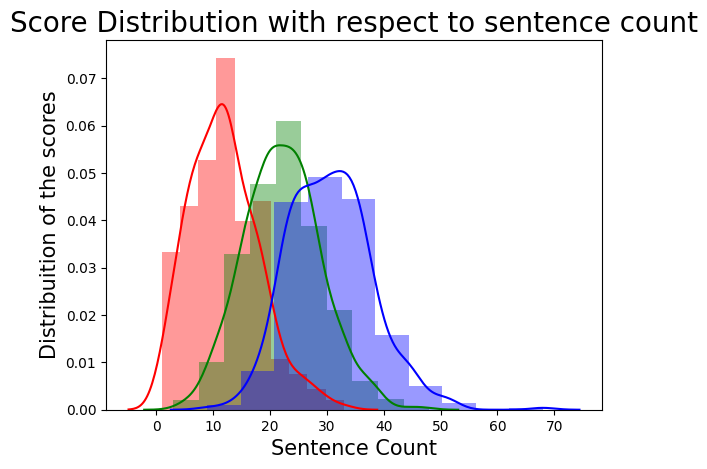

In [71]:
zero = data[(data["Sentence_Count"] > 0) & (scores == 0)]
one = data[(data["Sentence_Count"] > 0) & (scores == 1)]
two = data[(data["Sentence_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Sentence_Count"], bins=10, color='r')
sns.distplot(one["Sentence_Count"], bins=10, color='g')
sns.distplot(two["Sentence_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to sentence count",fontsize=20)
plt.xlabel("Sentence Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\4103004754.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zero["Word_Count"], bins=10, color='r')
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\4103004754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(one["Word_Count"], bins=10, 

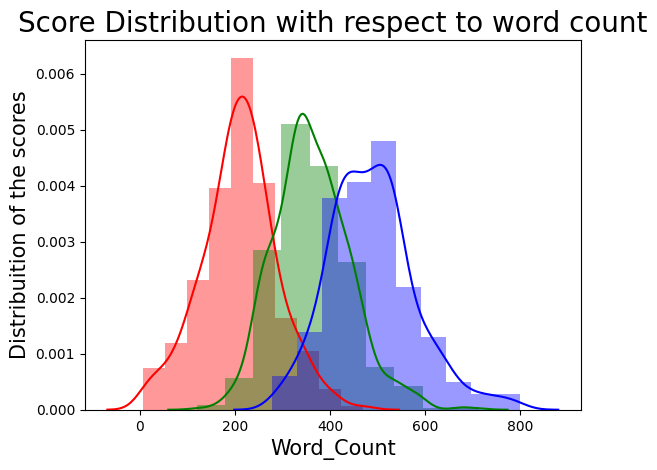

In [72]:
zero = data[(data["Word_Count"] > 0) & (scores == 0)]
one = data[(data["Word_Count"] > 0) & (scores == 1)]
two = data[(data["Word_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Word_Count"], bins=10, color='r')
sns.distplot(one["Word_Count"], bins=10, color='g')
sns.distplot(two["Word_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to word count",fontsize=20)
plt.xlabel("Word_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2845609831.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zero["Average_Word_Length"], bins=10, color='r')
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\2845609831.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(one["Average_Word_L

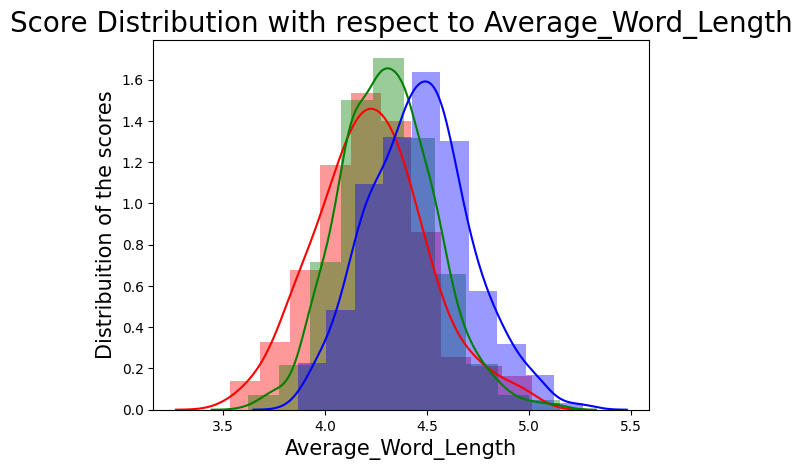

In [73]:
zero = data[(data["Average_Word_Length"] > 0) & (scores == 0)]
one = data[(data["Average_Word_Length"] > 0) & (scores == 1)]
two = data[(data["Average_Word_Length"] > 0) & (scores == 2)]
sns.distplot(zero["Average_Word_Length"], bins=10, color='r')
sns.distplot(one["Average_Word_Length"], bins=10, color='g')
sns.distplot(two["Average_Word_Length"], bins=10, color='b')
plt.title("Score Distribution with respect to Average_Word_Length",fontsize=20)
plt.xlabel("Average_Word_Length",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()


In [185]:
print("********* Auto Grading By Using KNearestNeighborClassifier ***********")

********* Auto Grading By Using KNearestNeighborClassifier ***********


In [186]:
neighbors = 6
components = 80

In [187]:
def StemmingWordList(arrayList):
    ps = nltk.PorterStemmer()
    newList = [ps.stem(word) for word in arrayList]
    return ''.join(newList)

svd = TruncatedSVD(n_iter=10, n_components=components)
tfidf = TfidfVectorizer(min_df = 0.01, max_df=0.85, stop_words='english')

In [188]:
#import data using essay_set_descriptions and valid_set_set1
train = pd.read_csv('essay_set_descriptions.csv')
test = pd.read_csv('valid_set_set1.csv')

train.set_index('essay_id')
test.set_index('essay_id')
y_train = train['domain1_score']
y_test = test['Score']
X = pd.concat([train,test])


In [189]:
#'essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',       'domain1_score

In [190]:
#Creating 2 addtional features
#"Number of words" and "Number of sentences" improve the accuracy

train_numberOfSentences = X['essay'].apply(lambda x: len(x.split('.')))
train_numberOfWords = X['essay'].apply(lambda x: len(x.split()))

In [191]:
content = X['essay']
content = content.apply(lambda x: re.sub('^[a-zA-Z]', ' ', x))
content = content.apply(lambda x: StemmingWordList(x))

In [192]:
x_transform = tfidf.fit_transform(content)

In [193]:
x_transform = sparse.hstack((x_transform, train_numberOfSentences[:,None]))
x_transform = sparse.hstack((x_transform, train_numberOfWords[:,None]))

C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\1077382334.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_transform = sparse.hstack((x_transform, train_numberOfSentences[:,None]))
C:\Users\Benjie\AppData\Local\Temp\ipykernel_16904\1077382334.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_transform = sparse.hstack((x_transform, train_numberOfWords[:,None]))


In [194]:
x_transform = svd.fit_transform(x_transform)

In [195]:
x_train = x_transform[:len(train)]
x_test = x_transform[len(train):]

In [196]:
nearestNeighbors = NearestNeighbors(n_neighbors=neighbors)
nearestNeighbors.fit(x_train)

NearestNeighbors(n_neighbors=6)

In [197]:
NearestNeighbors(n_neighbors=6)

NearestNeighbors(n_neighbors=6)

In [198]:
test_dist, test_ind = nearestNeighbors.kneighbors(x_test)

In [199]:
#Using custom median to predict score
i_prediction = list()
for i_dist in range(0, len(test_dist)):
    t = 0
    idx = 0
    avg = sum(test_dist[i_dist])/2
    for dist in test_dist[i_dist]:
        t += dist
        if (t < avg):
            idx += 1
        else:
            i_prediction.append(test_ind[i_dist][idx])
            break

In [200]:

prediction_list = list()
for i in i_prediction:
    prediction_list.append(y_train[i])
    

In [201]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
values = imp.fit([[1, 2], [np.nan, 3], [7, 6]])

In [202]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic')

0.07040741812101337

In [203]:
#Using true median for prediction

prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[round(neighbors/2)]])
    

In [204]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.0702904761825508

In [205]:
#Using closest item

prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[0]])

In [206]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.086771862057333

In [207]:
#Using mean of score

prediction_list = list()
for val in test_ind:
    total = 0
    for i in val:
        total += y_train[i]
    avg = round(total / len(val)) 
    prediction_list.append(avg)

In [208]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.20359009182602505